In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer

from ELPH_NVAR import SVDNVAR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
runs = ELPH_utils.load_runs()

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

# for k in range(len(runs)):
#     runs[k] = runs[k][:,:200:2]

100 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


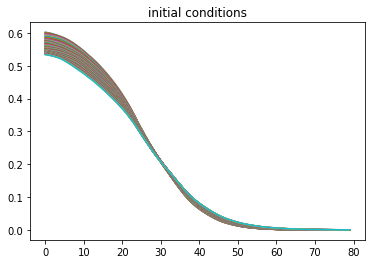

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('initial conditions')
plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 39900)
NVAR state shape:  (861, 39900)
target shape:  (20, 39900)
weights shape:  (861, 20)


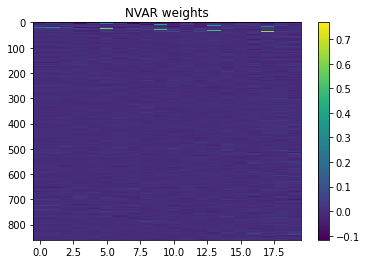

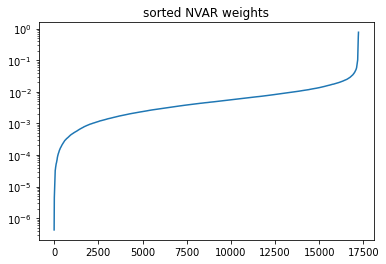

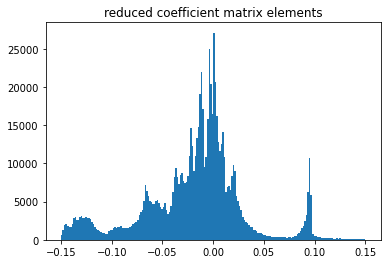

In [26]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)

# scaler = ELPH_Scaler.standardize_scaler()
scaler = ELPH_Scaler.normalize_scaler(0.3)
# scaler = ELPH_Scaler.tanh_scaler(arg_scale=1.0, out_scale=0.3)

NVAR = SVDNVAR(runs)
NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler)
NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(NVAR.red_coef_matrix), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

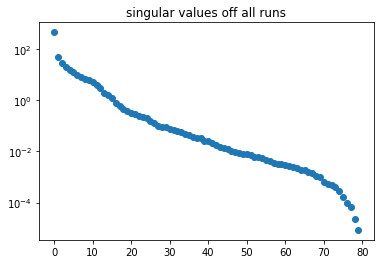

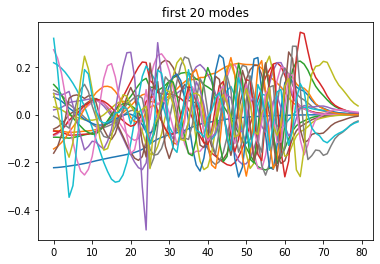

In [27]:
plt.semilogy(NVAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(NVAR.rdim):
  plt.plot(NVAR.U[:,l],  label='Uhat_'+str(l))
plt.title('first ' + str(NVAR.rdim) + ' modes')
plt.show()

In [28]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
scaler = ELPH_Scaler.normalize_scaler(0.3)

train_kwargs = {'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'intercept':True, 'optimizer':optimizer, 'scaler':scaler, 'full_hist':False}
score_kwargs = {'norm':'max', 'errSVD':True}

m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.0069617020140548425
0.0003967946466025677
[0.007180322919505486, 0.007619328794593686, 0.006789263109818355, 0.006731356865422061, 0.006488238380934619]


In [ ]:
def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)
    
    train_kwargs = {'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'intercept':True, 'optimizer':optimizer, 'scaler':scaler, 'full_hist':False}
    score_kwargs = {'norm':'max', 'errSVD':True}
    
    m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,0.7]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

# optimizer.maximize(init_points=10, n_iter=60)

In [ ]:
# scores = []

# k = 1

# for aExp in np.linspace(-4,-2,15):
#     for rs in np.linspace(0.2,0.5,15):
#         print(k)
#         scores.append(get_score(aExp,rs))
#         k += 1

In [ ]:
# scrs = np.array(scores)
# scrs = np.reshape(scrs,(15,15))


# plt.imshow(scrs, aspect='auto', origin='lower', vmin=-0.02, extent=[0.2,0.5,-4,-2])
# plt.colorbar()
# plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 39501)
NVAR state shape:  (861, 39501)
target shape:  (20, 39501)
weights shape:  (861, 20)
NVAR error:  0.007852762375874789
NVAR error compared to SVD approximated run:  0.004147533647577917


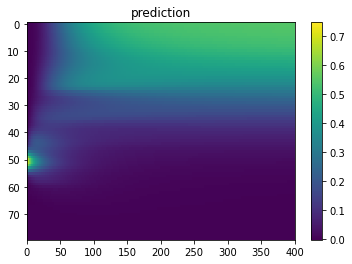

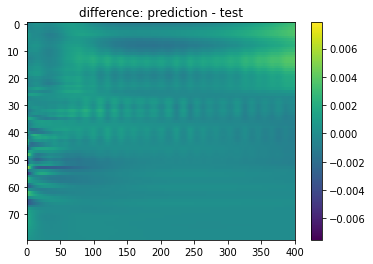

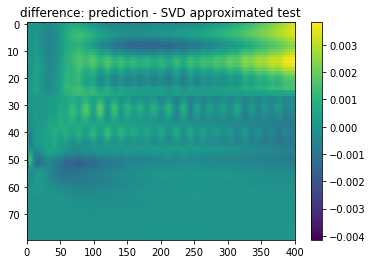

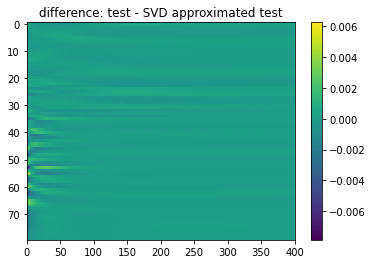

In [29]:
scaler = ELPH_Scaler.normalize_scaler(0.3)
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
# optimizer = ELPH_Optimizer.lstsqrs()


train_runs = runs[::1]
test_run = train_runs.pop(67)

NVAR.load_runs(train_runs)
NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler, full_hist=False)

NVAR.print_status()


print('NVAR error: ', NVAR.get_error(test_run, norm='max') )
print('NVAR error compared to SVD approximated run: ', NVAR.get_error(test_run, norm='max', errSVD=True) )

pred = NVAR.predict_single_run(test_run)
test_run_SVDapprx = NVAR.Uhat @ NVAR.Uhat.T @ test_run


xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

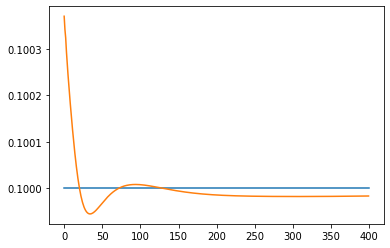

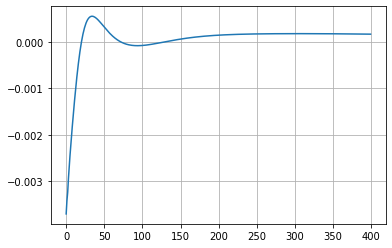

In [42]:
import ELPH_dyn

N_test = np.sum(test_run, axis=0)
N_pred = np.sum(pred, axis=0)

dk = 4./80.

def get_N(run):
    Narr = np.zeros(run.shape[1])
    for t in range(run.shape[1]):
        N = 0
        for k in range(run.shape[0]):
            N += run[k,t] * ELPH_dyn.get_k(dk,k)*dk/2./np.pi
        Narr[t] = N
        
    return Narr

N_test_noPI = get_N(test_run)
N_pred_noPI = get_N(pred)

plt.plot(N_test_noPI)
plt.plot(N_pred_noPI)
plt.show()

plt.grid()
plt.plot((N_test_noPI-N_pred_noPI)/N_test_noPI)
plt.show()

ridge regression loss: 0.05353095
epoch: 0 loss: 0.05373263
epoch: 1 loss: 0.05518255
epoch: 2 loss: 0.054690223
epoch: 3 loss: 0.053697523
epoch: 4 loss: 0.053343937
epoch: 5 loss: 0.053373307
epoch: 6 loss: 0.0533097
epoch: 7 loss: 0.05320228
epoch: 8 loss: 0.05315868
epoch: 9 loss: 0.053122584
epoch: 10 loss: 0.053067017
epoch: 11 loss: 0.053011503
epoch: 12 loss: 0.052982
epoch: 13 loss: 0.05291985
epoch: 14 loss: 0.05288195
epoch: 15 loss: 0.05282586
epoch: 16 loss: 0.052779622
epoch: 17 loss: 0.052745625
epoch: 18 loss: 0.052694045
epoch: 19 loss: 0.052701797
epoch: 20 loss: 0.052593723
epoch: 21 loss: 0.052534714
epoch: 22 loss: 0.052537397
epoch: 23 loss: 0.05248076
epoch: 24 loss: 0.052399427
epoch: 25 loss: 0.05234873
epoch: 26 loss: 0.05230251
epoch: 27 loss: 0.05224733
epoch: 28 loss: 0.052201934
epoch: 29 loss: 0.05215128
epoch: 30 loss: 0.0521166
epoch: 31 loss: 0.05211276
epoch: 32 loss: 0.05217424
epoch: 33 loss: 0.051990923
epoch: 34 loss: 0.051932253
epoch: 35 loss: 0

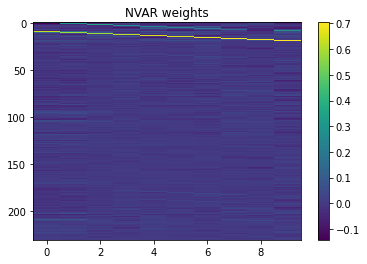

In [68]:
scaler = ELPH_Scaler.normalize_scaler(0.3)
# optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
optimizer = ELPH_Optimizer.PIML_adam(alpha=10.**-2.8, lambda1=10.0, epochs = 50, mini_batch_size = 5000)

train_runs = runs[::1]
test_run = train_runs.pop(82)

NVAR.load_runs(train_runs)
NVAR.train(rdim=10, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler, full_hist=False)

NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()


NVAR error:  0.04514824524020655


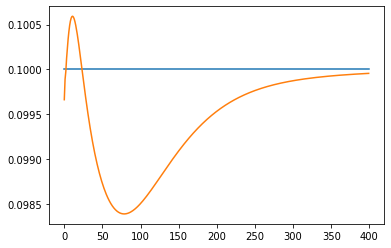

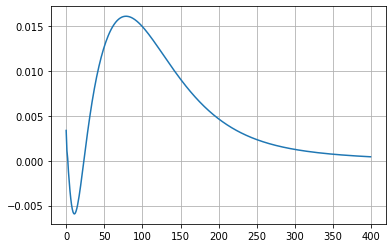

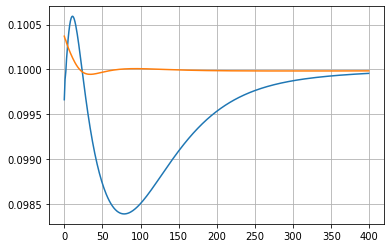

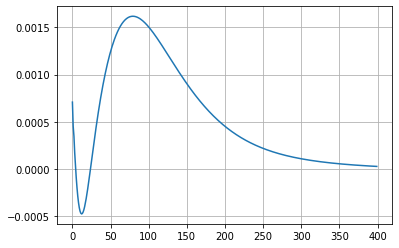

In [69]:
print('NVAR error: ', NVAR.get_error(test_run, norm='max') )


pred_PIML = NVAR.predict_single_run(test_run)


N_test = get_N(test_run)
N_pred = get_N(pred_PIML)

plt.plot(N_test)
plt.plot(N_pred)
plt.show()

plt.grid()
plt.plot((N_test-N_pred)/N_test)
plt.show()


plt.grid()
plt.plot(N_pred)
plt.plot(N_pred_noPI)
plt.show()

plt.grid()
plt.plot(N_pred_noPI-N_pred)
plt.show()